In [2]:
"""Machine-learning applications in computational chemistry."""

__authors__ = "B. G. Peyton"
__credits__ = ["Doaa Altarawy", "Matthew Welborn", "Daniel G. A. Smith"]
__email__   = ["bgpeyton@vt.edu"]

__copyright__ = "(c) 2008-2020, The Psi4Education Developers"
__license__   = "BSD-3-Clause"
__date__      = "2020-07-13"

#  Machine-learning applications in computational chemistry
## 0. Environment setup 

In [3]:
import psi4
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Introduction

Machine-learning (ML) is broadly defined as any algorithm which improves by feeding more data into the algorithm. Familiar concepts such as basic linear regression can be understood as applications of ML, where more data in the regression provides a better fit to a straight line which can then be used to predict new points. This is an example of **supervised** learning, where some input values (x) and output values (y) are known from the beginning. These values compose a **training set**, a defining feature of any ML method. Unsupervised learning is also possible, and is generally used for finding patterns in correlated data; however, we will restrict our discussion to supervised learning techniques.

ML has found applications across the physical sciences including (but not limited to) engineering, physics, biology, and chemistry. By utilizing training sets of molecules and their various properties, chemists can make use of ML algorithms by predicting molecular properties using only the molecular formula or structure without the need for time-consuming experiments. However, generating a robust database of reference values to train the ML model is a tedious task for experimental chemists. Computational chemistry provides a quick and consistent way to produce training data for a reference set of molecules. Once a model is trained with these reference data, properties for new molecules (or geometries of the same molecule) can be predicted at very low cost -- no experiment or electronic structure calculation required. 

## 2. Representing a molecule
The ML algorithms we will be using attempt to find a model $f({\bf x})$ which can map a representation vector $\bf x$ onto some target value $y$:
$$f({\bf x}) = {\bf x}^T {\bf w},$$

$$y = f({\bf x}) + \epsilon$$
where $\epsilon$ is the **noise** or **error** of the model. These equations define a simple linear regression model, where we have allowed the input vector (and therefor the weights, or slope) to be of arbitrary dimension.

For our purposes, $\bf x$ is some vector **representation** of our molecule, and $y$ is some property we'd like to predict, such as the energy. We will start by calculating the energy of the water molecule during the symmetric stretching of the O-H bonds, which will be the property $y$ in our model. The following code block will calculate the energy at 31 different bond lengths and save the geometry, charges, and energy at each bond length.

In [4]:
# run across an H2O symmetric bond stretching surface
# 0.5 - 2.0 Angstroms, increments of 0.05, total of 31 geometries
# use H-H bond angle 104.5 degrees
# save geometry, nuclear charges (same across the surface), and scf energy as lists

# set basis
psi4.set_options({
    'basis':'sto-3g'
})
# initialize geometry list
geoms = []
# initialize charge list
qs = []
# initialize energy list
Es = []
# generate bond lengths
rs = []
for i in range(0,31):
    rs.append(0.5 + i*0.05)

# loop over bond lengths
for i in rs:
    # generate a water molecule using a Z-matrix and set the O-H bond lengths
    mol = psi4.geometry("""
    O
    H 1 """ + str(i) + """
    H 1 """ + str(i) + """ 2 104.5
    """)
    # save the geometry
    geoms.append(mol.geometry().to_array())
    
    # save the charges for all three atoms as a list
    q = []
    for a in range(0,3):
        q.append(mol.fZ(a))
    qs.append(q)
    
    # calculate and save the energy
    Es.append(psi4.energy('scf'))
    

In the next cell, the change in the energy as the length of the O-H bonds change is plotted as a slice of the potential energy surface.

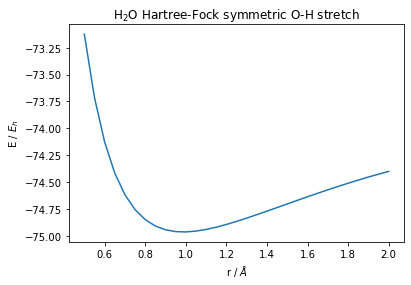

In [5]:
# plot the original surface
plt.plot(rs,list(Es))
plt.title("H$_2$O Hartree-Fock symmetric O-H stretch")
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

At a glance, the energy seems to be a simple function of the bond length $r$. One could formulate this as a simple regression problem and solve for a function that maps $r$ into the energy $E$. However, if one wishes to explore more than the symmetric stretch, more information about the molecule is necessary. We want to describe every bond in the molecule.

To do this, we can encode the geometry of the molecule into a matrix using each atom distance $r_{ij}$ - that is, the distance between every pair of atoms. To differentiate the O-H bond length from the H-H "bond", we will use the atomic charge $Z$ of each atom. The resulting matrix is called a **Coulomb matrix** $\bf C$, which takes the form:
$$
\begin{align}
C_{ij} = 
\begin{cases}
\frac{Z_iZ_j}{r_{ij}}&\text{for $i \neq j$}\\
0.5Z_i^{2.4}&\text{for $i=j$}\\
\end{cases}
\end{align}
$$

In [6]:
# ==> Build coulomb matrices according to the above equation <==
     
def coulomb(geom,q):
    '''
    Generates the coulomb matrix given a geometry and list of atomic charges
    
    Parameters:
    geom: list of lists of atomic coordinates, [[xi,yi,zi],[xj,yj,zj],...]
    q: list of atomic charges, [qi,qj,...]
    
    Returns:
    cm: np.ndarray, coulomb matrix
    '''
    natom = len(q)
    cm = np.zeros((natom,natom)) # ==> Fill this matrix! <==
    dist = lambda i, j :np.linalg.norm(np.array(geom[i])-np.array(geom[j]))
    for i in range(0,len(q)):
        for j in range(0,len(q)):
            if i==j:
                cm[i][j]=0.5*q[i]**2.4
            else:
                cm[i][j]=(q[i]*q[j])/dist(i,j)
                   
    return cm
# Generate the coulomb matrix for all geometries and store them in a list
couls = []
for i in range(0,len(geoms)):
    coul = coulomb(geoms[i],qs[i])
    couls.append(coul)

In [7]:
print(couls[0])

[[73.51669472  8.46683537  8.46683537]
 [ 8.46683537  0.5         0.66926039]
 [ 8.46683537  0.66926039  0.5       ]]


The above cell should evaluate to:
```
[[73.51669472  8.46683537  8.46683537]
 [ 8.46683537  0.5         0.66926039]
 [ 8.46683537  0.66926039  0.5       ]]
 ```

**STUDENT QUESTIONS:**

A. `mol.geometry()` always returns the geometry in cartesian units Bohr. How would the Coulomb matrix compare if you used different units for your bond distances?

B. Why do we not scale the diagonal elements by the bond distance?

**Answers:** 

A. It will be multiplied by a conversion factor to get the desired units, like rescaling. 

B. Because of the symmetry 

## 2. Training a ML model for molecular energy
Now we may take our Coulomb matrix elements and use them as features for a ML model. We will flatten $\bf C$ into a 1D array $\bf c$ (using the `numpy` function `ndarray.flatten()`), then find the optimum weights $\bf w$ which map the features onto the energy:

$$y \approx f({\bf x}) = {\bf c}^T {\bf w}.$$

Finding the weights is done by calling `fit(x,y)` on a `LinearRegression` object, which was imported from the `scikit-learn` ML package at the top of this notebook. The resulting model can then be used to `predict` values for any new representations.

**STUDENT QUESTION:** If our feature vector $\bf c$ is a vector containing all of the elements of $\bf C$, how many elements will there be in our weight vector $\bf w$?

**Answer:** It must contain the same number of element in $\bf c$

We will now select some points to train the ML model, and try predicting the energy for every other point. Since we know what the curve will look like, we can evaluate the accuracy of our model. Execute the following code blocks to see how the model performs.

In [8]:
# set up a training set (X,y) - 4 evenly-spaced points on the PES
trainers = [0,7,15,23] 
X_train = []
y_train = []
for t in trainers:
    X_train.append(couls[t].flatten())
    y_train.append(Es[t])

# prediction set will be everything else
testers = []
for i in range(0,31):
    testers.append(i)
# remove the training set!
for t in sorted(trainers,reverse=True):
    del testers[t]
# set up test set (X,y)
X_test = []
y_test = []
for t in testers:
    X_test.append(couls[t].flatten())
    y_test.append(Es[t])

# use Linear Regression from scikit-learn to train and predict
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)

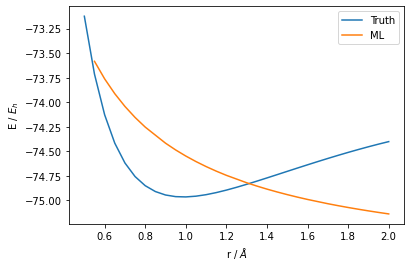

In [9]:
# plot the true and ML surfaces
plt.plot(rs,list(Es),label='Truth')
plt.plot(np.asarray(rs)[testers],y_pred,label='ML')
plt.legend()
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

This model did not perform admirably. However, `scikit-learn` provides many pre-packaged ML algorithms which are more appropriate for this job. Let's try again, but instead of linear regression we use the popular **Kernel Ridge Regression** model. This model solves a modified linear regression equation:

$$
y \approx f({\bf x}) = \sum_i w_i k({\bf x},{\bf x'}_i)
$$

where $i$ runs over the training set (${\bf x'}$). The regression coefficients $\bf w$ are defined by

$$
{\bf w} \triangleq ({\bf K}({\bf x'},{\bf x'}) + \alpha{\bf I})^{-1}{\bf y}
$$

where $\bf I$ is the identity matrix. This method differs from linear regression in two key ways. The first is the inclusion of a dampening parameter (called a **hyperparameter**), $\alpha$, which is optimized during training and protects against over-training. The next difference is the use of a **kernel**, vector $k$ or matrix $\bf{K}$, which measures the **similarity** of two inputs $\bf x$ and ${\bf x'}$ rather than using the inputs themselves. There are many possible kernel definitions, but we will choose the popular radial basis function kernel:

$$
{\bf K}({\bf x},{\bf x'}) = exp(-\gamma||{\bf x} - {\bf x'}||^2)
$$

where $\gamma$ is included as an additional optimizable hyperparameter determined at training time to determine the "width" of the kernel. The hyperparameters are optimized by simply trying many different values, and choosing the combination which gives the best results on a subset of the training data in a process called cross-validation.
(NOTE: the algorithm must never be shown the test data until final evaluation!)

`scikit-learn` can build this model given the training set and a few starting parameters with just a few lines of code, shown below.

In [10]:
# building the kernel ridge regression model
krr = KernelRidge(kernel='rbf')
# define hyperparameter grid: 12 points from 1E-12 to 1E12 for each
parameters = {'alpha':np.logspace(-12,12,num=12),
              'gamma':np.logspace(-12,12,num=12)}
# build the model - 4-fold grid search CV w/ NMSE scoring function
krr_regressor = GridSearchCV(krr,parameters,cv=4,scoring='neg_mean_squared_error')
# train the model on the training set
krr_regressor.fit(X_train,y_train)
# predict the test set
y_pred = krr_regressor.predict(X_test)

We will plot our results with `matplotlib` again, this time using an inset plot to zoom-in.

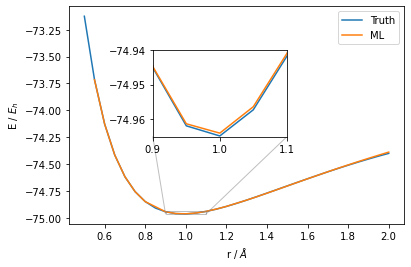

In [11]:
plt.plot(rs,list(Es),label='Truth')
plt.plot(np.asarray(rs)[testers],y_pred,label='ML')

ax = plt.gca()
axin = ax.inset_axes([0.25,0.4,0.4,0.4])
axin.plot(rs,list(Es))
axin.plot(np.asarray(rs)[testers],y_pred)
axin.set_xlim([0.9,1.1])
axin.set_ylim([-74.965,-74.94])
axin.set_alpha(0)
ax.indicate_inset_zoom(axin,label='_nolegend_')

plt.legend()
plt.xlabel('r / $\AA$')
plt.ylabel('E / $E_h$')
plt.show()

As you can see, the inclusion of multiple optimizable parameters and the use of a kernel vastly improves the flexibility of our model. Now that we have a model that seems to work, we will try a more complex system.

## 4. Predicting a hypersurface
Of course, we do not need to limit ourselves to the symmetric stretch. The asymmetric stretch of water, a function of both O-H bond distances, can also be explored. Complete the following code to compute the hypersurface - you should try all values of `rs` for each bond, so reduce the number of rs to 16 instead of 31 (still ranging from 0.5 to 2 Angstroms). Running the calculations may take a few minutes.

In [25]:
# ==> Generate the slice of the hypersurface where both bonds stretch independently. <==

psi4.set_options({
    'basis':'sto-3g'
})
# Es[i][j]=(psi4.energy('scf'))
# initialize geometry list
geoms = []
# initialize charge list
qs = []
# initialize energy list
# generate bond lengths
rs = []
for i in range(0,16):
    rs.append(0.5 + i*0.1)
Es = np.zeros((len(rs),len(rs)))
# loop over bond lengths
for i in range(0,16):
    for j in range(0,16):
                # generate a water molecule using a Z-matrix and set the O-H bond lengths
        mol = psi4.geometry("""
        O
        H 1 """ + str(rs[i]) + """
        H 1 """ + str(rs[j]) + """ 2 104.25
        """)
        # save the geometry
        geoms.append(mol.geometry().to_array())

        # save the charges for all three atoms as a list
        q = []
        for a in range(0,3):
            q.append(mol.fZ(a))
        qs.append(q)
        Es[i][j]=(psi4.energy('scf'))

Since we now want to plot the energy against two variables ($r_1$ and $r_2$), we can use a contour plot. The color will show us the deviation from the minimum at each point, $(r_1,r_2)$.

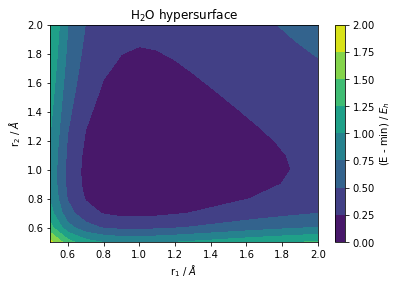

Mean prediction error across the surface: 0.3937469737033133 Hartrees


In [27]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(rs,rs,(Es - np.min(Es)))
cbar = fig.colorbar(cp,label="(E - min) / $E_h$")
ax.set_title('H$_2$O hypersurface')
ax.set_xlabel('r$_1$ / $\AA$')
ax.set_ylabel('r$_2$ / $\AA$')
plt.show()
print("Mean prediction error across the surface: {} Hartrees".format(np.mean(np.abs(Es - np.min(Es)))))

If the calculations have run correctly, the above cell should produce the following graph:
![contour](data/h2o_contour.png)
We can see that there is a broad energy well, meaning that many different bond distances produce energies near the minimum. Reproducing this well is key for a useful ML model of the system. 

In the following cells, choose a number of training points and attempt to reproduce the above hypersurface. See if you can find the lowest number of training points to still get a good fit!

NOTE: you can choose the training points however you like. You may wish to try evenly-spaced points, points near the minima or maxima of the hypersurface, or even random points! (Hint: for the latter, try `np.random.randint`)

In [15]:
# ==> Generate the coulomb matrix for all geometries <==
couls = []
for i in range(0,len(geoms)):
    coul = coulomb(geoms[i],qs[i])
    couls.append(coul)

In [174]:
# ==> Make your training set - X and y values.
# Remember: you must flatten each individual Coulomb matrix, but also the whole energy array

trainers = [-14,-10,-6,5,7,-7,0,2,4,8] 
X_train = []
y_train = []
for t in trainers:
    X_train.append(couls[t].flatten())
    y_train.append(Es[t][t].flatten())
len(y_train)

10

In [175]:
# ==> Finally, use Scikit-Learn to build a model to predict the rest of the surface <==
krr = KernelRidge(kernel='rbf')
parameters = {'alpha':np.logspace(-12,12,num=12),
              'gamma':np.logspace(-12,12,num=12)}
krr_regressor = GridSearchCV(krr,parameters,cv=4,scoring='neg_mean_squared_error')

# ==> COMPLETE THE FUNCTION CALL <==
krr_regressor.fit(X_train,y_train) 

GridSearchCV(cv=4, estimator=KernelRidge(kernel='rbf'),
             param_grid={'alpha': array([1.00000000e-12, 1.51991108e-10, 2.31012970e-08, 3.51119173e-06,
       5.33669923e-04, 8.11130831e-02, 1.23284674e+01, 1.87381742e+03,
       2.84803587e+05, 4.32876128e+07, 6.57933225e+09, 1.00000000e+12]),
                         'gamma': array([1.00000000e-12, 1.51991108e-10, 2.31012970e-08, 3.51119173e-06,
       5.33669923e-04, 8.11130831e-02, 1.23284674e+01, 1.87381742e+03,
       2.84803587e+05, 4.32876128e+07, 6.57933225e+09, 1.00000000e+12])},
             scoring='neg_mean_squared_error')

The following cell will predict the entire surface, including the training set, to make plotting easier. We will also look at the average error across the surface. How does it compare?

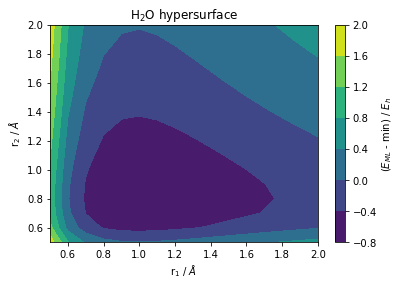

Mean prediction error across the surface: 0.6079689308884904 Hartrees


In [176]:
y_pred = krr_regressor.predict([c.flatten() for c in couls])
fig,ax=plt.subplots(1,1)
cp = ax.contourf(rs,rs,(y_pred.reshape(16,16) - np.min(Es)))
cbar = fig.colorbar(cp,label="($E_{ML}$ - min) / $E_h$")
ax.set_title('H$_2$O hypersurface')
ax.set_xlabel('r$_1$ / $\AA$')
ax.set_ylabel('r$_2$ / $\AA$')
plt.show()
print("Mean prediction error across the surface: {} Hartrees".format(np.mean(np.abs(y_pred - Es.flatten()))))

**STUDENT QUESTION:** The shape of the well may be reproduced, but "chemical accuracy" in computational chemistry is generally 1kcal/mol. Does your model reach this (on average)?

**Answer:** No, my model has an error of about 376 kcal/mol which is significant

## 5. Atomization energies and the ANI-1 dataset
We can also apply the same logic to many different molecules. A variant of the Coulomb matrix can be generated for molecules from the ANI-1 dataset, a collection of over 57 thousand organic molecules with up to 8 heavy (non-Hydrogen) atoms and their properties. Large datasets such as these can be used to train models to predict properties for new molecules without needing to perform an expensive calculation. 

Below, a subset of the ANI-1 dataset is loaded into a Pandas dataframe containing the energy from an electronic structure calculation, a molecule object, the Coulomb matrix (`feature`), and the atomization energy (`AE`) for a 1000-molecule training set and 100-molecule test set. The Pandas dataframe acts as a powerful dictionary for storing large datasets.

In [19]:
data_train = pd.read_pickle('data/ani1_train.pd')
data_test = pd.read_pickle('data/ani1_test.pd')

Now, all of our data is collected into just two objects which can be indexed by name, similarly to a Python `dict` object. Another advantage of this dataframe is that every entry can be visualized within a Jupyter notebook. Feel free to explore the different molecules present.

In the cells below, train a new kernel ridge regression model. Then, evaluate the error for predicting the atomization energies of the test and training sets. The error on the training sets gives us a "lower bound" to what we hope the error in the test set to be. If the training set performs poorly, we know our model must be revised.

In [20]:
# ==> Pandas dictionaries allow us to store features and data in one place. <==
# ==> Select the appropriate dictionary keys to build the training and test sets. <==
X_train = np.vstack(data_train["feature"])
y_train = data_train["AE"].values
X_test = np.vstack(data_test["feature"])
y_test = data_test["AE"].values

In [21]:
# ==> train the model and predict for both the test and training set <==
# ==> this will take a moment <==
krr = KernelRidge(kernel='rbf')
parameters = {'alpha':np.logspace(-12,12,num=12),
              'gamma':np.logspace(-12,12,num=12)}
krr_regressor = GridSearchCV(krr,parameters,cv=4,scoring='neg_mean_squared_error')

# ==> COMPLETE THE FUNCTION CALLS <==
krr_regressor.fit(X_train,y_train)
[c.flatten() for c in couls]
y_pred_test = krr_regressor.predict(X_test)
y_pred_train = krr_regressor.predict(X_train)

Finally, we will plot the errors in a violin plot. The y-axis will tell us the error, while the width of the violin tells us the density (frequency) of points with that error. In other words, the widest point tells us the error where most of the data points fall. The minimum, maxiumum, and mean errors are marked by horizontal lines.

Mean prediction error across the test set: 0.08322858730516941 Hartrees


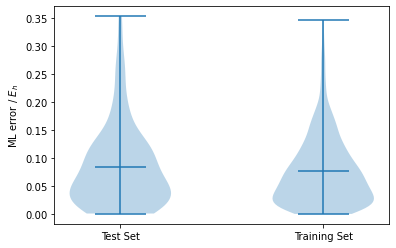

In [22]:
test_err = np.abs(y_test - y_pred_test)
train_err = np.abs(y_train - y_pred_train)

fig,ax = plt.subplots(1,1)
ax.violinplot([test_err,train_err],showmeans=True)
ax.set_xticks([1,2])
ax.set_xticklabels(["Test Set","Training Set"])
ax.set_ylabel('ML error / $E_h$')
print("Mean prediction error across the test set: {} Hartrees".format(np.mean(test_err)))

**STUDENT QUESTION:**
Are these errors significant or negligible? Should the model be revised? Discuss your reasoning.

**Answer:** The error remains significant. However, there is a big improvement comparing to previous models. An error reduction of about 87% from 376 kcal/mol to 50 kcal/mol